[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


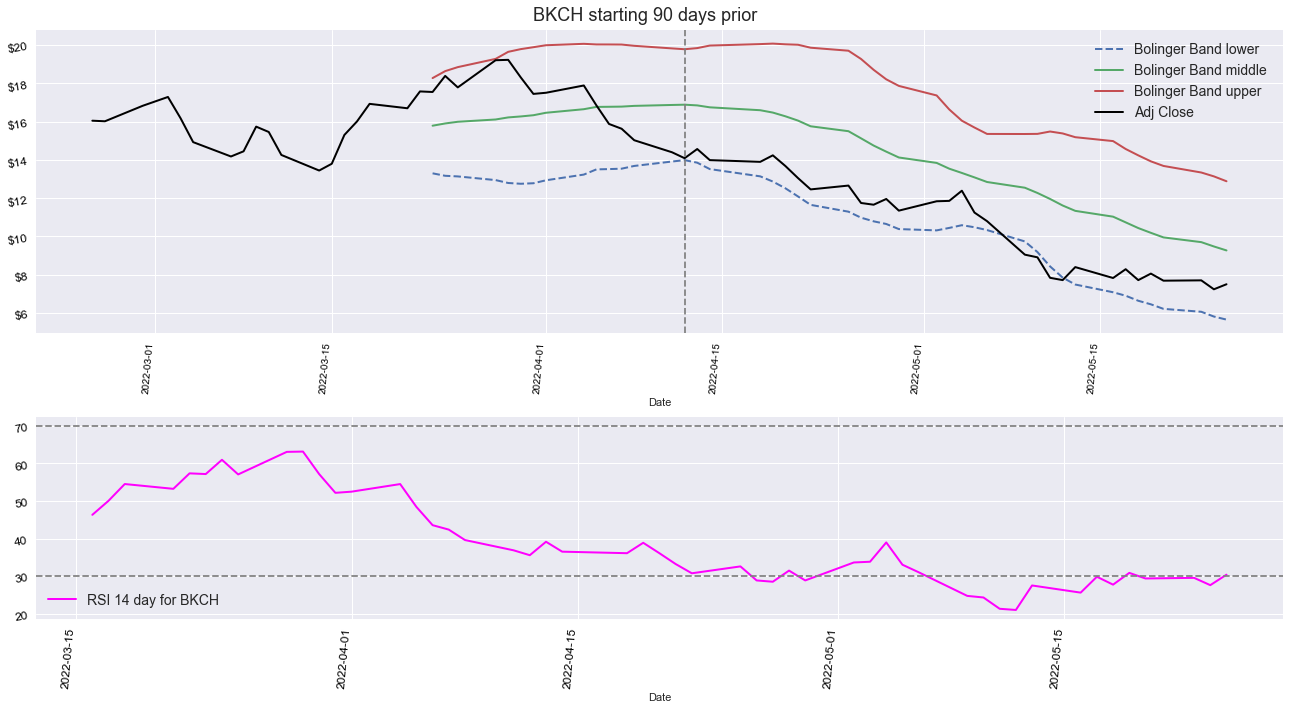

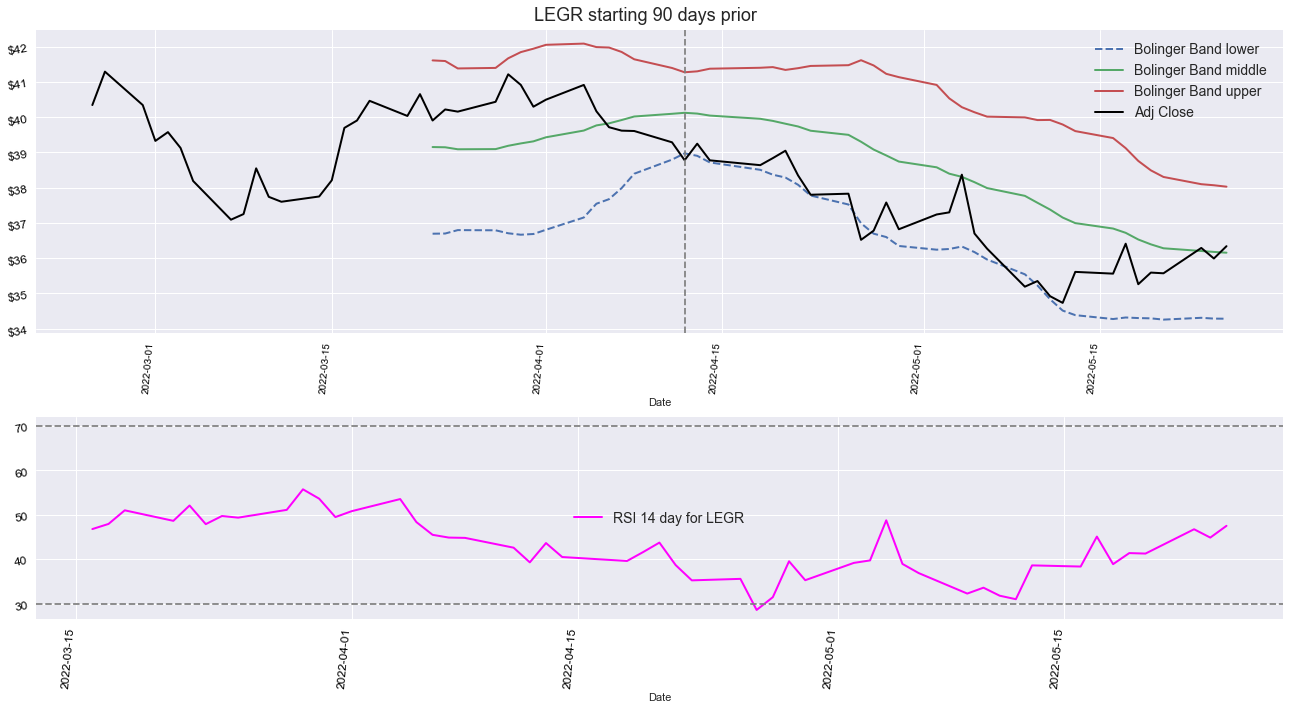

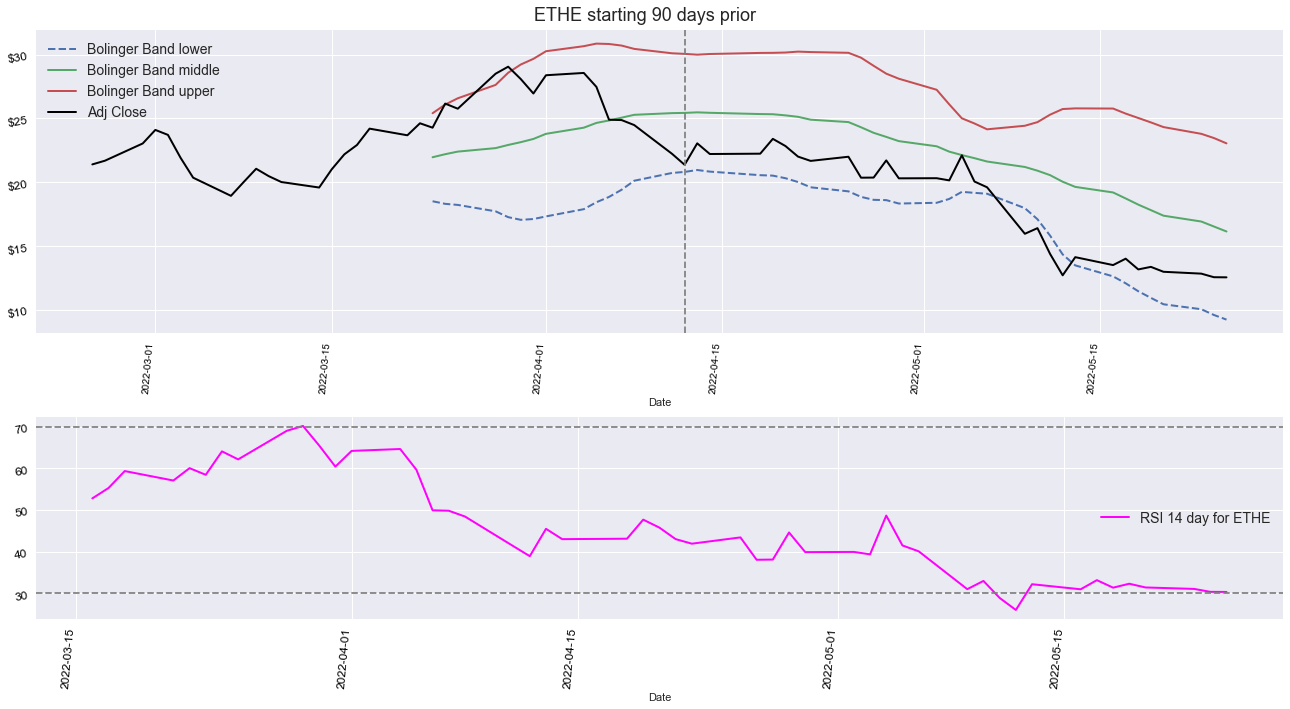

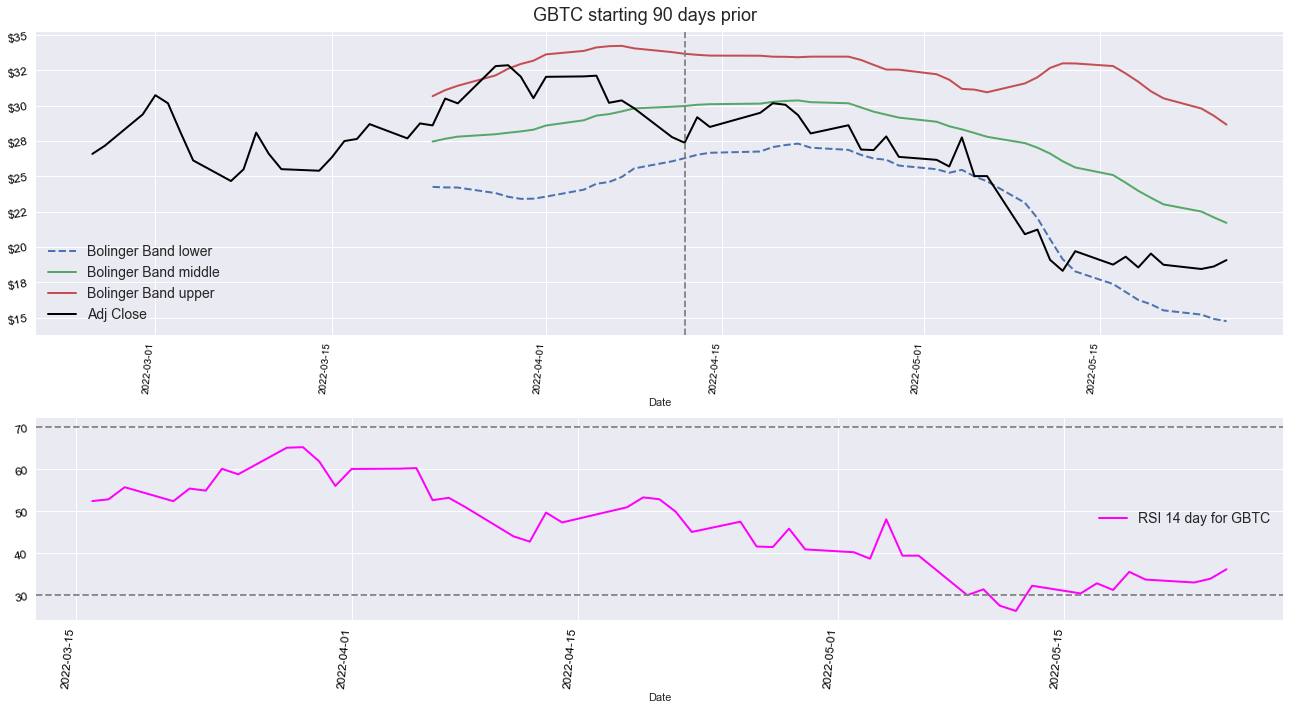

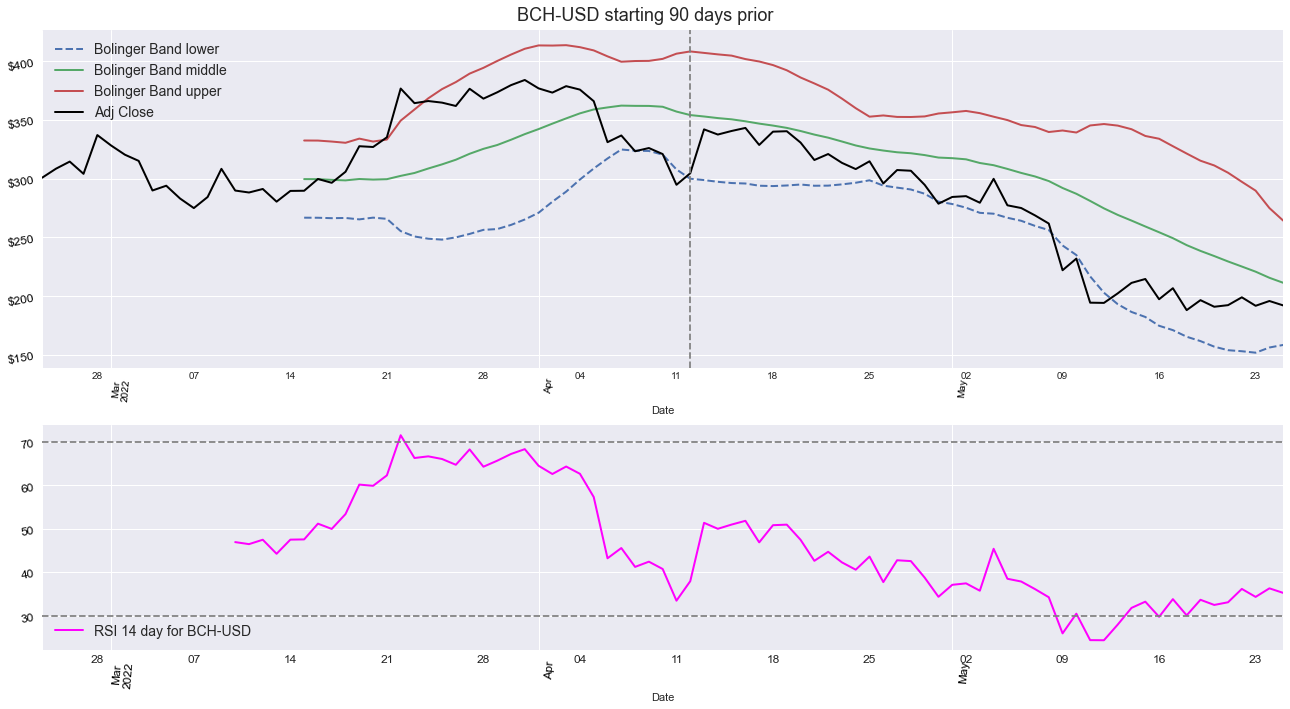

In [18]:
import pandas as pd
import numpy as np
import os
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas.plotting import scatter_matrix
from dataclasses import dataclass, asdict, astuple
from datetime import date
#conda install -c conda-forge ruamel.yaml
#pip install yfinance
import yfinance as yf
#python -m pip install ––upgrade pi
%matplotlib inline
#pip install ta
#pip install --upgrade ta
from ta import add_all_ta_features
from ta.utils import dropna
#pip install pandas-ta
import pandas_ta as pta
from datetime import date, timedelta
#conda install -c conda-forge ta-lib
import talib

import fontstyle
'''
test running the df in a generator, yield first then using that later such that the dfs from yf.download
spent 1.5hrs on this 2022-05-22 07:34:58 
'''
########
pd.set_option('display.max_rows', None)  #this prints out all rows of data
pd.set_option('display.max_columns', None)

#.................
@dataclass
class DATA():
    symbol_tuple = ('BKCH', 'LEGR', 'ETHE', 'GBTC', 'BCH-USD')
    #, 'TQQQ', 'BTC'
    SYMBOL: str = symbol_tuple
    TAIL_OFDF_FORPLOT: int = 90  #days
    start = "2022-02-01"  #etrade started 03/26/2004, use 2004-04-01 2019-09-01 is a good date for ema, etc.  

##########
symbols_size = len(DATA.SYMBOL)
end = pd.to_datetime("today")
td = timedelta(90)
startdate_tddays_back = end-td
####################################
#print(td.days) #got lucky on this guess, it's basically a dictionary

def create_df_from_generator(symbols, startdate):
    for s in symbols:
        df = yf.download(s, startdate, end)
        df.index = pd.to_datetime(df.index) #this may not be necessary.
        #data = df.history()
        yield df

def display_dfs():
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)
    for t in range(0, symbols_size):
        df_for_display = pd.DataFrame(dfs_from_generatorlist[t])

    for t in range(0, symbols_size):
        print(f'df for {DATA.SYMBOL[t]}')
        df_for_display['SMA_10'] = df_for_display.ta.sma(length=10)
        df_for_display['SMA_20'] = df_for_display.ta.sma(length=20)
        df_for_display['SMA_30'] = df_for_display.ta.sma(length=30)
        df_for_display = df_for_display.iloc[:,].fillna(0)
        df_for_display = df_for_display.astype(float)
        pd.options.display.float_format = "{:,.0f}".format
        display(df_for_display)  
        #df_for_display.info()
    
def ema_dfs_from_list_longertimeperiod():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, '2019-09-01')  #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    for t in range(0, symbols_size):
        dfewm = pd.DataFrame(dfs_from_generatorlist[t])
        dfewm_COPY = dfewm.copy()
        LOW_SCALAR = dfewm_COPY['Adj Close'].min()
        HIGH_SCALAR = dfewm_COPY['Adj Close'].max()
        dfewm_COPY['EMA'] = dfewm_COPY['Adj Close'].ewm(span=180,
                                                        adjust=False).mean()
        DF_SMA = dfewm.copy()
        SMA = DF_SMA.ta.sma(length=200)
        #display(SMA_200)
        fig, (ax1) = plt.subplots(1, 1, figsize=(18, 10)) #width, height
        '''
        https://rbdundas.medium.com/calculate-relative-strength-index-rsi-and-chart-with-candles-using-python-pandas-and-matplotlib-f58d926249ac
        2022-05-23 10:39:24  less than 1hr to figure out this guys code and adjust it to work.
        '''
        ################################ 
        width = .5 #for red
        width2 = .05 #for green
        col1 = 'green'
        col2 = 'red'
        dfewm_COPY2 = dfewm.copy()
        df_up_down = pd.DataFrame()
        df_up_down['open'] = dfewm_COPY2['Open']
        df_up_down['high'] = dfewm_COPY2['High']
        df_up_down['low'] = dfewm_COPY2['Low']
        df_up_down['close'] = dfewm_COPY2['Adj Close']
        up = df_up_down[df_up_down.close >= df_up_down.open]
        down = df_up_down[df_up_down.close < df_up_down.open]
        #display(up.head(30))
        #display(down.head(30))
        #########################################
        ax1.bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
        ax1.bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
        ax1.bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)
        ax1.bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
        ax1.bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
        ax1.bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)
        #############################
        dfewm_COPY['Adj Close'].plot(ax=ax1,
                                     label=DATA.SYMBOL[t] + ' Adj Close',
                                     color='gray',
                                     linestyle='--',
                                     linewidth=.5,
                                     legend=True)
        dfewm_COPY['EMA'].plot(ax=ax1,
                               label='EMA 200 Days',
                               color='g',
                               linestyle='--',
                               linewidth=3,
                               legend=True)
        SMA.plot(ax=ax1,
                 label='SMA 200 Days',
                 color='orange',
                 linestyle='--',
                 linewidth=3,
                 legend=True)
        plt.axhline(y=LOW_SCALAR, color='gray', linestyle='--')
        plt.axhline(y=HIGH_SCALAR, color='gray', linestyle='--')
        plt.axvline(x='2022-04-12', color='grey', linestyle='--')
        plt.axvline(x='2022-05-04', color='grey', linestyle='--')
        plt.axvline(x='2022-05-18', color='grey', linestyle='--')
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')
        plt.title('__')
        plt.show()


def volume_dfs_from_list():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    #symbols_size = len(symbols)
    for t in range(0, symbols_size):
        dfv = pd.DataFrame(dfs_from_generatorlist[t])
        dfv_COPY = dfv.copy()
        LOW_SCALAR = dfv_COPY['Volume'].min()
        HIGH_SCALAR = dfv_COPY['Volume'].max()
        dfv_COPY['EMA'] = dfv_COPY['Volume'].ewm(span=180, adjust=False).mean()
        #display(SMA_200)
        fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))
        dfv_COPY['Volume'].plot(ax=ax1,
                                label=DATA.SYMBOL[t] + ' Volume',
                                color='b',
                                linestyle='-',
                                linewidth=3,
                                legend=True)
        dfv_COPY['EMA'].plot(ax=ax1,
                             label='EMA 200 Days',
                             color='g',
                             linestyle='--',
                             linewidth=3,
                             legend=True)
        plt.axhline(y=LOW_SCALAR, color='gray', linestyle='--')
        plt.axhline(y=HIGH_SCALAR, color='gray', linestyle='--')
        plt.axvline(x='2022-04-12', color='grey', linestyle='--')
        plt.axvline(x='2022-05-04', color='grey', linestyle='--')
        plt.axvline(x='2022-05-18', color='grey', linestyle='--')
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')
        plt.title('__')
        plt.show()


def pandas_ta_bolingerbands():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    plt.rcParams["figure.figsize"] = [15, 6]
    #symbols_size = len(symbols)
    for t in range(0, symbols_size):
        dfp = pd.DataFrame(dfs_from_generatorlist[t])
        dfp_COPY = dfp.copy()
        pta_df = pta.bbands(dfp_COPY["Adj Close"], length=20, talib=False)
        (pta_df[["BBL_20_2.0", "BBM_20_2.0",
                 "BBU_20_2.0"]].plot(title="Bolinger Bands (pandas_ta) for " +
                                     DATA.SYMBOL[t]))
        
        dfforSMA = pd.DataFrame(dfs_from_generatorlist[t])
        dfforSMA = dfforSMA.iloc[:,].fillna(0)
        DF_SMA2 = dfforSMA.copy()
        DF_SMA2["Adj Close"] = DF_SMA2["Adj Close"]
        ###########
        #SMA_2 = DF_SMA2.ta.sma(length=20)
        DF_SMA2["Adj Close"].plot(label='Adj Close', color='black', linestyle='--', linewidth=2, legend=True)
        plt.axvline(x='2022-04-12', color='grey', linestyle='--')
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')

def adjusted_close_SMAs():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    for t in range(0, symbols_size):
        dfewm = pd.DataFrame(dfs_from_generatorlist[t])
        dfewm_COPY = dfewm.copy()
        dfewm_COPY = dfewm_COPY.iloc[:,].fillna(0)
        LOW_SCALAR = dfewm_COPY['Adj Close'].min()
        HIGH_SCALAR = dfewm_COPY['Adj Close'].max()
        #display(SMA_200)
        ####################
        dfforSMA = pd.DataFrame(dfs_from_generatorlist[t])
        dfforSMA = dfforSMA.iloc[:,].fillna(0)
        DF_SMA1 = dfforSMA.copy()
        DF_SMA2 = dfforSMA.copy()
        DF_SMA5 = dfforSMA.copy()
        ###########
        SMA_1 = DF_SMA1.ta.sma(length=10)
        SMA_2 = DF_SMA2.ta.sma(length=20)
        SMA_5 = DF_SMA5.ta.sma(length=30)
        ####################
        fig, (ax1) = plt.subplots(1, 1, figsize=(18, 10)) #width, height
        dfewm_COPY['Adj Close'].plot(ax=ax1,
                                     label=DATA.SYMBOL[t] + ' Adj Close',
                                     color='green',
                                     linestyle='-',
                                     linewidth=3,
                                     legend=True)

        SMA_1.plot(ax=ax1, label='SMA 10', color='magenta', linestyle='--', linewidth=2, legend=True)
        SMA_2.plot(ax=ax1, label='SMA 20', color='b', linestyle='--', linewidth=2, legend=True)
        SMA_5.plot(ax=ax1, label='SMA 30', color='orange', linestyle='--', linewidth=2, legend=True)
        plt.axhline(y=LOW_SCALAR, color='gray', linestyle='--')
        plt.axhline(y=HIGH_SCALAR, color='gray', linestyle='--')
        plt.axvline(x='2022-04-12', color='grey', linestyle='--')
        plt.axvline(x='2022-05-04', color='grey', linestyle='--')
        plt.axvline(x='2022-05-18', color='grey', linestyle='--')
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')
        plt.title('__')
        plt.show()

        
        
def adjusted_close_SMAs_CandleSticks():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    for t in range(0, symbols_size):
        dfewm = pd.DataFrame(dfs_from_generatorlist[t])
        dfewm_COPY = dfewm.copy()
        dfewm_COPY = dfewm_COPY.iloc[:,].fillna(0)
        LOW_SCALAR = dfewm_COPY['Adj Close'].min()
        HIGH_SCALAR = dfewm_COPY['Adj Close'].max()
        #display(SMA_200)
        ####################
        dfforSMA = pd.DataFrame(dfs_from_generatorlist[t])
        dfforSMA = dfforSMA.iloc[:,].fillna(0)
        DF_SMA1 = dfforSMA.copy()
        DF_SMA2 = dfforSMA.copy()
        DF_SMA5 = dfforSMA.copy()
        ###########
        SMA_1 = DF_SMA1.ta.sma(length=10)
        SMA_2 = DF_SMA2.ta.sma(length=20)
        SMA_5 = DF_SMA5.ta.sma(length=30)
        ######################
        '''
        https://www.investopedia.com/trading/candlestick-charting-what-is-it/
        Candlesticks are useful when trading as they show four price points 
        open, close, high (spline), and low (spline) 
        throughout the period of time the trader specifies.
        '''
        width = .5 #for red
        width2 = .05 #for green
        col1 = 'green'
        col2 = 'red'
        dfewm_COPY2 = dfewm.copy()
        df_up_down = pd.DataFrame()
        df_up_down['open'] = dfewm_COPY2['Open']
        df_up_down['high'] = dfewm_COPY2['High']
        df_up_down['low'] = dfewm_COPY2['Low']
        df_up_down['close'] = dfewm_COPY2['Adj Close']
        up = df_up_down[df_up_down.close >= df_up_down.open]
        down = df_up_down[df_up_down.close < df_up_down.open]
        #display(up.head(30))
        #display(down.head(30))
        fig, (ax1) = plt.subplots(1, 1, figsize=(18, 10)) #width, height
        #########################################
        ax1.bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
        ax1.bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
        ax1.bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)
        ax1.bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
        ax1.bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
        ax1.bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)
        #############################
        dfewm_COPY['Adj Close'].plot(ax=ax1,
                                     label=DATA.SYMBOL[t] + ' Adj Close',
                                     color='black',
                                     linestyle='--',
                                     linewidth=2,
                                     legend=True)
        #########
        SMA_1.plot(ax=ax1, label='SMA 10', color='magenta', linestyle='--', linewidth=2, legend=True)
        SMA_2.plot(ax=ax1, label='SMA 20', color='b', linestyle='--', linewidth=2, legend=True)
        SMA_5.plot(ax=ax1, label='SMA 30', color='orange', linestyle='--', linewidth=2, legend=True)
        plt.axhline(y=LOW_SCALAR, color='gray', linestyle='--')
        plt.axhline(y=HIGH_SCALAR, color='gray', linestyle='--')
        plt.axvline(x='2022-04-12', color='grey', linestyle='--')
        plt.axvline(x='2022-05-04', color='grey', linestyle='--')
        plt.axvline(x='2022-05-18', color='grey', linestyle='--')
        # use formatters to specify major and minor ticks
        import matplotlib.dates as mdates
        #ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        #ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
        #_ = plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter('${x:,.0f}')
        plt.title('__')
        plt.show()

def bolingerbands_rsi():
    global generatorlist
    generatorlist = create_df_from_generator(DATA.SYMBOL, startdate_tddays_back) #key discovery 2022-05-24 18:51:40 
    dfs_from_generatorlist = list(generatorlist)  #this puts the results into a list to be extracted
    plt.style.use("seaborn")
    font = {'family': 'Arial',
        'color':  'black',
        'weight': 'bold',
        'size': 32, #this is not changing the size
        }
    box = {'facecolor': 'white',
       'edgecolor': 'blue',
       'boxstyle': 'round',
      }
    #plt.style.use('fivethirtyeight')
    for t in range(0, symbols_size):
        dfp = pd.DataFrame(dfs_from_generatorlist[t])
        pta_df = pta.bbands(dfp["Adj Close"], length=20, talib=False)
        BBL_20_2 = pta_df["BBL_20_2.0"]
        BBM_20_2 = pta_df["BBM_20_2.0"]
        BBU_20_2 = pta_df["BBU_20_2.0"]
        #######################
        df_adjclose = pd.DataFrame(dfs_from_generatorlist[t])
        df_adjclose = df_adjclose.iloc[:,].fillna(0)
        df_adjclose["Adj Close"] = df_adjclose["Adj Close"]
        ##################
        df_rsi = pd.DataFrame(dfs_from_generatorlist[t])
        df_rsi = df_rsi.iloc[:,].fillna(0)
        rsi_14day = talib.RSI(df_rsi["Adj Close"])
        #display(rsi_14day)
        ####the figure must go here after dfs above or it does not plot each ticker symbol
        fig = plt.figure(figsize=(18, 10)) #width, height
        gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[1.5, 1])
        ###########################
        ax1 = fig.add_subplot(gs[0, 0])
        BBL_20_2.plot(ax=ax1, label="Bolinger Band lower ",
                                           linestyle='--', 
                                           linewidth=2, 
                                           legend=True)
        BBM_20_2.plot(ax=ax1, label="Bolinger Band middle ",
                                           linestyle='-', 
                                           linewidth=2, 
                                           legend=True)
        BBU_20_2.plot(ax=ax1, label="Bolinger Band upper ",
                                           linestyle='-', 
                                           linewidth=2, 
                                           legend=True)
        df_adjclose["Adj Close"].plot(ax=ax1, label='Adj Close', 
                                           color='black', 
                                           linestyle='-', 
                                           linewidth=2, 
                                           legend=True)
        ax1.axvline(x='2022-04-12', color='grey', linestyle='--')
        ax1.yaxis.set_major_formatter('${x:,.0f}')
        ax1.yaxis.set_tick_params(rotation=10,
                         labelsize=12 ,
                         labelcolor = "black")
        ax1.xaxis.set_tick_params(rotation=85,
                         labelsize=10 ,
                         labelcolor = "black")
        ax1.legend(fontsize = 14, facecolor = "white", loc=0)
        ###########
        ax2 = fig.add_subplot(gs[1, 0])
        rsi_14day.plot(ax=ax2, label='RSI 14 day for ' + DATA.SYMBOL[t], 
                                           color='magenta', 
                                           linestyle='-', 
                                           linewidth=2, 
                                           fontsize=12,
                                           legend=True)
        #ax2.axhline(y='30', color='grey', linestyle='--')  
        ax2.axhline(y=30, color='gray', linestyle='--')
        ax2.axhline(y=70, color='gray', linestyle='--')
        ax2.yaxis.set_major_formatter('{x:,.0f}')
        ax2.yaxis.set_tick_params(rotation=10,
                         labelsize=12 ,
                         labelcolor = "black")
        ax2.xaxis.set_tick_params(rotation=85,
                         labelsize=12 ,
                         labelcolor = "black")
        ax2.legend(fontsize = 14, facecolor = "white", loc=0)
        #fig.suptitle(DATA.SYMBOL[t] + ' starting ' + str(td.days) +' days prior', fontdict=font, bbox=box)
        fig.suptitle(DATA.SYMBOL[t] + ' starting ' + str(td.days) +' days prior', fontsize=18)
        plt.tight_layout(pad=1, w_pad=2, h_pad=1) 
        
#display_dfs()
#adjusted_close_SMAs_CandleSticks()        
#volume_dfs_from_list()
#pandas_ta_bolingerbands()
#adjusted_close_SMAs()
#ema_dfs_from_list_longertimeperiod()
bolingerbands_rsi()


